In [1]:
from hcdr import make_prep_pipeline, load_process_data
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, precision_recall_curve, f1_score
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime
import warnings
import pprint

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.calibration import calibration_curve

from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss

from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score

In [2]:
from IPython.display import display, HTML, Javascript

js_getResults = """<script>
alert("Hello! I am an alert box!");
</script>"""

def alert():
    display(HTML(js_getResults))

In [3]:
%%time
processed_data, num_attribs, cat_attribs = load_process_data()
y = processed_data['TARGET']
X = processed_data

data_prep_pipeline = make_prep_pipeline(num_attribs, cat_attribs)

loaded data


/Users/deepakduggirala/Documents/courses/AML526/home-credit-default-risk/main/hcdr.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[mask] = np.NaN
/Users/deepakduggirala/miniforge3/envs/ml/lib/python3.10/site-packages/pandas/core/frame.py:3718: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)
/Users/deepakduggirala/Documents/courses/AML526/home-credit-default-risk/main/hcdr.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pand

CPU times: user 25.1 s, sys: 11.3 s, total: 36.4 s
Wall time: 42.6 s


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
X_train.shape, X_valid.shape, X_test.shape

((184506, 354), (61502, 354), (61503, 354))

In [5]:
%%time
np.random.seed(42)
pipeline_with_selector = Pipeline([
    ("preparation", data_prep_pipeline),
    ("feature_selector", SelectFromModel(LogisticRegression(
        C=0.006,
        penalty='l1',
        solver='liblinear',
        class_weight='balanced',
        max_iter=1000,
        random_state=0))),
])

_ = pipeline_with_selector.fit(X_train, y_train)

CPU times: user 31.4 s, sys: 1.66 s, total: 33 s
Wall time: 33.6 s


In [6]:
cat_pipeline = data_prep_pipeline.transformer_list[1][1]
cat_features = [f'{base}_{c}'for base, ohe_c in zip(
    cat_attribs, cat_pipeline.named_steps['ohe'].categories_) for c in ohe_c]
features = num_attribs + cat_features
print(f'features: {len(features)}, num_attribs: {len(num_attribs)}, cat_features: {len(cat_features)}')

selector_model = pipeline_with_selector.named_steps['feature_selector']
selected_features = list(np.array(features)[selector_model.get_support()])
print(f'attribs: {len(num_attribs + cat_attribs)}, features: {len(features)}, selected_features={len(selected_features)}')

selected_attribs = set([f if f in num_attribs else '_'.join(f.split('_')[:-1]) for f in selected_features])
unused_attribs = set(num_attribs+cat_attribs) - selected_attribs

features: 491, num_attribs: 287, cat_features: 204
attribs: 334, features: 491, selected_features=173


In [7]:
X_train_xfm = pipeline_with_selector.transform(X_train)
X_valid_xfm = pipeline_with_selector.transform(X_valid)
X_test_xfm = pipeline_with_selector.transform(X_test)
X_train_xfm.shape, X_valid_xfm.shape, X_test_xfm.shape

((184506, 173), (61502, 173), (61503, 173))

In [8]:
%%time
model = LinearSVC(class_weight='balanced', random_state=0, max_iter=10000, dual=False)
model.fit(X_train_xfm, y_train)

CPU times: user 41.9 s, sys: 337 ms, total: 42.2 s
Wall time: 42.7 s


LinearSVC(class_weight='balanced', dual=False, max_iter=10000, random_state=0)

In [9]:
def get_sample_weights(y):
    # only works if y is one dimensional array of 0s and 1s
    f1 = np.sum(y)/y.shape[0]
    f0 = 1-f1
    w0,w1 = 0.5/f0, 0.5/f1
    return np.where(y_valid==0, w0, w1)

In [10]:
%%time
calib_model = CalibratedClassifierCV(base_estimator=model, method='isotonic', cv='prefit')
calib_model.fit(X_valid_xfm, y_valid, sample_weight=get_sample_weights(y_valid))

CPU times: user 111 ms, sys: 91.1 ms, total: 203 ms
Wall time: 63.5 ms


CalibratedClassifierCV(base_estimator=LinearSVC(class_weight='balanced',
                                                dual=False, max_iter=10000,
                                                random_state=0),
                       cv='prefit', method='isotonic')

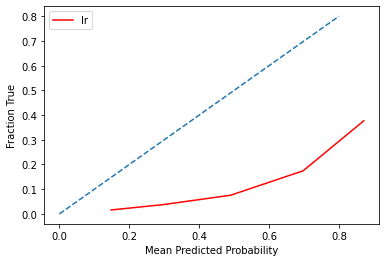

In [11]:
n_bins=5
plt.plot(np.arange(0,1,1/n_bins), np.arange(0,1,1/n_bins), '--')
y_test_pred_proba = calib_model.predict_proba(X_test_xfm)[:,1]
prob_true, prob_pred = calibration_curve(y_test, y_test_pred_proba, n_bins=n_bins)
plt.plot(prob_pred, prob_true, 'r', label='lr' )
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction True')
plt.legend() 

In [12]:
brier_score_loss(y_test, y_test_pred_proba)

0.1958401798155941

In [13]:
prob_true, prob_pred

(array([0.01603329, 0.03748252, 0.07571437, 0.17451066, 0.3768315 ]),
 array([0.1480211 , 0.29592362, 0.49031243, 0.69750526, 0.87114577]))

(array([ 1749., 12319.,  8866.,  7706.,  9332.,  7296.,  5595.,  4275.,
         2717.,  1648.]),
 array([0.        , 0.09471501, 0.18943002, 0.28414503, 0.37886004,
        0.47357505, 0.56829006, 0.66300507, 0.75772008, 0.85243509,
        0.9471501 ]),
 <BarContainer object of 10 artists>)

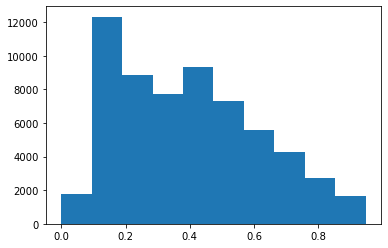

In [14]:
plt.hist(y_test_pred_proba)

In [15]:
thresh=0.5
np.sum(y_test_pred_proba>thresh), np.sum(y_test), accuracy_score(y_test, y_test_pred_proba>thresh), 1-np.mean(y_test)

(20953, 4928, 0.693819813667626, 0.9198738272929776)

In [16]:
y_train_pred_proba = calib_model.predict_proba(X_train_xfm)[:, 1]
y_valid_pred_proba = calib_model.predict_proba(X_valid_xfm)[:, 1]
y_test_pred_proba = calib_model.predict_proba(X_test_xfm)[:, 1]
np.round((
    roc_auc_score(y_train, y_train_pred_proba), 
    roc_auc_score(y_valid, y_valid_pred_proba), 
    roc_auc_score(y_test, y_test_pred_proba)
), 4)

array([0.7723, 0.7728, 0.7699])